# Cerebral Cortex Synthetic ECG Generation from the WESAD data set

> Run the following 2 cells ONLY if in Colab else skip them. They will install miniconda on Colab. Before running, first activate GPU by: Edit > Notebook settings > Hardware accelerator > GPU > Save

In [ ]:
!pwd
!which python
!python --version
#Check if GPU is detected
!nvidia-smi

In [ ]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
IN_COLAB = 'google.colab' in sys.modules
# If in Colab, install conda/mamba using condacolab python package and 
# wait until kernel restarts after the installation
if IN_COLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install_miniconda()

> Start running from following cell after kernel restarts OR when running locally on linux without dependencies installed. Don't run the cells above this.

In [5]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
IN_COLAB = 'google.colab' in sys.modules

## Check notebook dependencies

In [ ]:
HAVE_CARDIOGEN = importlib.util.find_spec("CardioGen") is not None

if(not HAVE_CARDIOGEN):
    if IN_COLAB: 
        print("\nGetting CardioGen")
        !git clone https://github.com/SENSE-Lab-OSU/cardio_gen_model.git
        !conda env update -n base -f ./cardio_gen_model/conda_requirements_linux.yml
        !pip install ./cardio_gen_model
    else:
        raise SystemExit("Please install CardioGen from https://github.com/SENSE-Lab-OSU/cardio_gen_model.git")
else:
    print("CardioGen found")

## Check mFlow and Cerebral-Cortex dependencies

In [6]:
JAVA_HOME_DEFINED = "JAVA_HOME" in os.environ
SPARK_HOME_DEFINED = "SPARK_HOME" in os.environ
PYSPARK_PYTHON_DEFINED = "PYSPARK_PYTHON" in os.environ
PYSPARK_DRIVER_PYTHON_DEFINED = "PYSPARK_DRIVER_PYTHON" in os.environ
HAVE_MFLOW = importlib.util.find_spec("mFlow") is not None
print(JAVA_HOME_DEFINED,SPARK_HOME_DEFINED,PYSPARK_PYTHON_DEFINED,PYSPARK_DRIVER_PYTHON_DEFINED,HAVE_MFLOW)

    
if(not HAVE_MFLOW):
    if IN_COLAB: 
        !git clone https://github.com/mlds-lab/mFlow.git
        !pip install ./mFlow
    else:
        raise SystemExit("Please install mFlow from https://github.com/mlds-lab/mFlow.git")
else:
    print("mFlow found")
        
if not JAVA_HOME_DEFINED:
    if IN_COLAB:
        if not os.path.exists("/usr/lib/jvm/java-8-openjdk-amd64/"): 
            print("\nGetting Java 8 SDK")
            !sudo apt update
            !apt-get install -y openjdk-8-jdk-headless 
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"
    else:
        raise SystemExit("Please install the Java8 SDK and set the JAVA_HOME environment variable")
else:
    print("JAVA_HOME defined")


if not SPARK_HOME_DEFINED:
    if IN_COLAB:
        if not os.path.exists("/content/spark-3.1.2-bin-hadoop2.7/"):
            print("\nGetting Apache Spark 3.1.2")
            !wget  https://mirrors.ocf.berkeley.edu/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
            !tar xf spark-3.1.2-bin-hadoop2.7.tgz
        os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7/"
    else:
        raise SystemExit("Please install spark-3.1.2-bin-hadoop2.7 and set the SPARK_HOME environment variable")
else:
    print("SPARK_HOME defined")


if not PYSPARK_PYTHON_DEFINED:
    if IN_COLAB:
        os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
    else:
        raise SystemExit("Please set the PYSPARK_PYTHON environment variable to your desired Python version")
else:
    print("PYSPARK_PYTHON defined")
            
if not PYSPARK_DRIVER_PYTHON_DEFINED:
    if IN_COLAB:
        os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
    else:
        raise SystemExit("Please set the PYSPARK_DRIVER_PYTHON environment variable to your desired Python version")
else:
    print("PYSPARK_DRIVER_PYTHON defined")

True True True True True


## Import library functions

> Start running from following cell when running locally on linux with all dependencies installed. Don't run the cells above this.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import neurokit2 as nk
import glob
import pickle
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
#sys.path.append('E:/agarwal270/Research/Projects/mFlow')

from mFlow.Utilities.utilities import getDataDir
from cerebralcortex.kernel import Kernel
from cerebralcortex.util.helper_methods import get_study_names
get_study_names()
#from cerebralcortex.core.datatypes.datastream import DataStream
import requests, tarfile

In [2]:
def wesad_data_download(data_size="all"):
    '''
    Downloads WESAD data if needed
    '''
    base_data_dir       = getDataDir()
    compressed_data_dir = os.path.join(base_data_dir,"compressed")
    wesad_data_dir      = os.path.join(base_data_dir,"wesad_"+data_size)
    wesad_cc_dir        = os.path.join(wesad_data_dir,"cc_data")

    if(data_size=="all"):
        compressed_file="cc_data.tar.bz2"
    elif(data_size=="small"):
        compressed_file="s2_data.tar.bz2"

    compressed_data_url="http://mhealth.md2k.org/images/datasets/%s"%compressed_file
    compressed_data_local_file = os.path.join(compressed_data_dir,compressed_file)

    #Make all data directories
    for d in [base_data_dir, compressed_data_dir, wesad_data_dir]:
        if(not os.path.exists(d)):
            os.mkdir(d)

    #Check if cc data store exists:
    if(not os.path.exists(wesad_cc_dir)):
        
        #Check if compressed cc version of the data set exists
        if(not os.path.isfile(compressed_data_local_file)):
            print("Downloading WESAD data archive to %s "%compressed_data_local_file,end="")
            #Download the compressed data file
            response = requests.get(compressed_data_url, stream=True)
            response.raise_for_status()
            with open(compressed_data_local_file , 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024*1024): 
                    f.write(chunk)
                    print(".",end="",flush=True)
            print("")
            print("Done")
        
        #Extract the data set
        print("Extracting WESAD data archive to %s ..."%wesad_cc_dir,end="",flush=True)
        tar = tarfile.open(compressed_data_local_file)
        tar.extractall(wesad_data_dir)
        tar.close()
        print(" Done")
        
class_name='S2'
data_size='all'
base_data_dir       = getDataDir()
compressed_data_dir = os.path.join(base_data_dir,"compressed")
wesad_data_dir      = os.path.join(base_data_dir,"wesad_"+data_size)
wesad_cc_dir        = os.path.join(wesad_data_dir,"cc_data")

#Download the data if needed
if (not os.path.exists(wesad_cc_dir)):
    wesad_data_download(data_size='all')

In [3]:
#Create CC kernel to load WESAD data
cc_configs = {"nosql_storage": "filesystem", 
          "filesystem":{"filesystem_path": wesad_cc_dir },
          "relational_storage": "sqlite",
          "sqlite": {"file_path": wesad_cc_dir },
         }
CC = Kernel(cc_configs=cc_configs, study_name="wesad")
CC.sqlContext.sql("set spark.sql.shuffle.partitions=1")
print(CC.list_streams())

#Get all the ecg data
CC_datastream = CC.get_stream("wesad.chest.ecg")

['wesad.chest.acc', 'wesad.chest.ecg', 'wesad.chest.eda', 'wesad.chest.emg', 'wesad.chest.resp', 'wesad.chest.temp', 'wesad.label', 'wesad.quest', 'wesad.wrist.acc', 'wesad.wrist.bvp', 'wesad.wrist.eda', 'wesad.wrist.temp']


Py4JJavaError: An error occurred while calling o71.load.
: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:645)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1230)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1435)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:493)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1868)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1910)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:678)
	at org.apache.spark.util.HadoopFSUtils$.listLeafFiles(HadoopFSUtils.scala:225)
	at org.apache.spark.util.HadoopFSUtils$.$anonfun$parallelListLeafFilesInternal$1(HadoopFSUtils.scala:95)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at scala.collection.AbstractTraversable.map(Traversable.scala:108)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFilesInternal(HadoopFSUtils.scala:85)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFiles(HadoopFSUtils.scala:69)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$.bulkListLeafFiles(InMemoryFileIndex.scala:158)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.listLeafFiles(InMemoryFileIndex.scala:131)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.refresh0(InMemoryFileIndex.scala:94)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.<init>(InMemoryFileIndex.scala:66)
	at org.apache.spark.sql.execution.datasources.DataSource.createInMemoryFileIndex(DataSource.scala:581)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:417)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:325)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$3(DataFrameReader.scala:307)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:307)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:239)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [10]:
from CardioGen.lib.data import load_data_wesad as load_data

def get_user_ecg_data(CC_datastream,P_ID="S2"):
    P_ID=P_ID.lower()
    #Get user's ecg data
    filtered_user_data = CC_datastream.filter_user(P_ID)
    #filtered_user_data.show(3,truncate=False)
    #data.show(3, truncate=False)
    #Convert CC DataStream to numpy()
    df=filtered_user_data.toPandas()
    #df_mini=df.iloc[:1000,:]
    ecg_from_CC=df['ecg'].values.astype(np.float32)
    #Resample ecg from 700Hz to 100Hz since current generative model works at 100 Hz
    ecg_resamp=load_data.resample(ecg_from_CC.reshape(-1,1),700,1,7)
    return ecg_resamp

In [11]:
P_ID_in, P_ID_out='S7','S15'

#Get Data. This step can take a lot of time due to pyspark to numpy datatype conversion
lenth=700000
ecg_in = (get_user_ecg_data(CC_datastream,P_ID=P_ID_in))[-lenth:]
ecg_out = (get_user_ecg_data(CC_datastream,P_ID=P_ID_out))[-lenth:]

E:/agarwal270/Research/Projects/cardio_gen_model/model
HRV Gen Model Exists. Loading ...
Restored from data/post-training/model_weights_v11/W_HRV_gen_model\ckpt-2000
Done!
ECG Morph model Exists. Loading ...
Restored from data/post-training/model_weights_v11/S7_ecg_stitch_model\ckpt-687
Done!


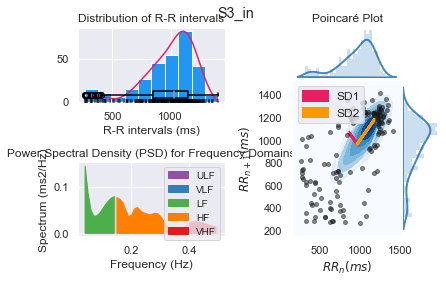

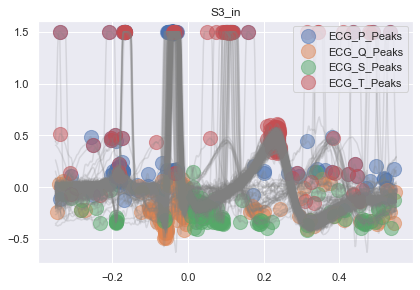

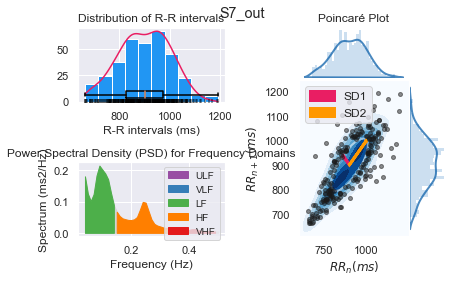

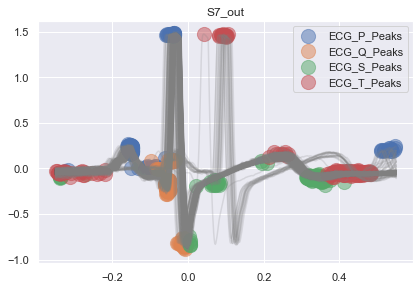

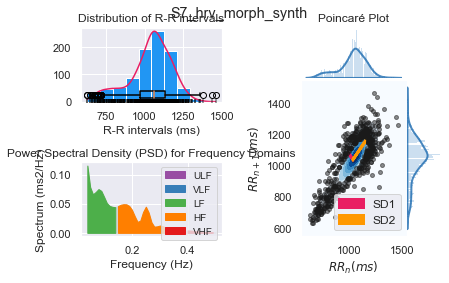

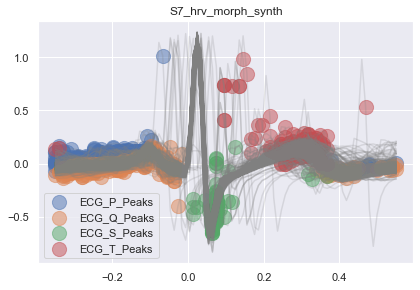

In [18]:
from CardioGen.modulators import ECG_HRV_Morph_Modulator, ECG_Morph_Modulator, ECG_HRV_Modulator
#ckpt_path='data/post-training/'
ckpt_path='./cardio_gen_model/data/post-training/'
Fs_in=100
Fs_out=100 #Synthetic signal sampling freq

# ECG HRV+Morph modulation
hrv_morph_mod=ECG_HRV_Morph_Modulator(P_ID_out=P_ID_out,
                                path=ckpt_path,
                                Fs_out=Fs_out)
# Produce synthetic from S15 to S15 itself to check performance of models
ecg_hrv_morph_mod_check,_=hrv_morph_mod(ecg_out,Fs=Fs_in)
# Produce synthetic from S7 to S15
ecg_hrv_morph_mod,_=hrv_morph_mod(ecg_in,Fs=Fs_in)

# Analyze HRV and Morphological properties
morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_out.flatten()
                            ,Fs=Fs_in,title_hrv=P_ID_out+'_out',
                            title_morph=P_ID_out+'_out')
morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_hrv_morph_mod_check
                            ,Fs=Fs_out,title_hrv=P_ID_out+'_hrv_morph_synth_check',
                            title_morph=P_ID_out+'_hrv_morph_synth_check')

morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_in.flatten()
                            ,Fs=Fs_in,title_hrv=P_ID_in+'_in',
                            title_morph=P_ID_in+'_in')
morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_hrv_morph_mod
                            ,Fs=Fs_out,title_hrv=P_ID_out+'_hrv_morph_synth',
                            title_morph=P_ID_out+'_hrv_morph_synth')

ECG Morph model Exists. Loading ...
Restored from data/post-training/model_weights_v11/S7_ecg_stitch_model\ckpt-687
Done!


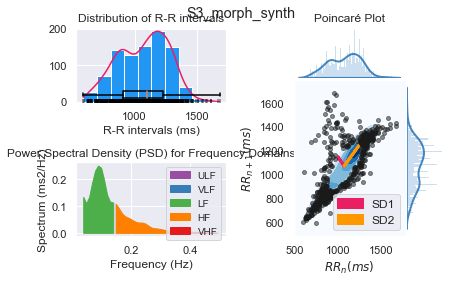

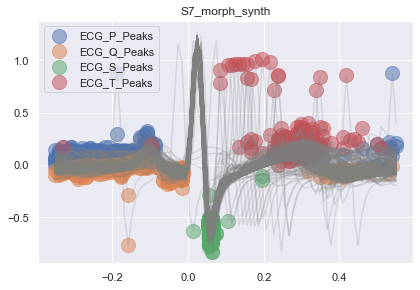

In [15]:
# ECG Morph modulation
morph_mod=ECG_Morph_Modulator(P_ID_out=P_ID_out,
                              path=ckpt_path,Fs_out=Fs_out)
ecg_morph_mod,_=morph_mod(ecg_in,Fs=Fs_in)

morph_features,hrv_features= morph_mod.analyse_signal(ecg_morph_mod
                            ,Fs=Fs_out,title_hrv=P_ID_in+'_morph_synth',
                            title_morph=P_ID_out+'_morph_synth')

HRV Gen Model Exists. Loading ...
Restored from data/post-training/model_weights_v11/W_HRV_gen_model\ckpt-2000
Done!
ECG Morph model Exists. Loading ...
Restored from data/post-training/model_weights_v11/S3_ecg_stitch_model\ckpt-687
Done!

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



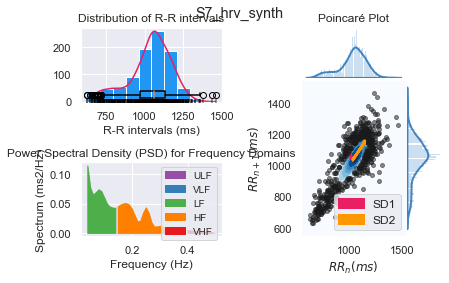

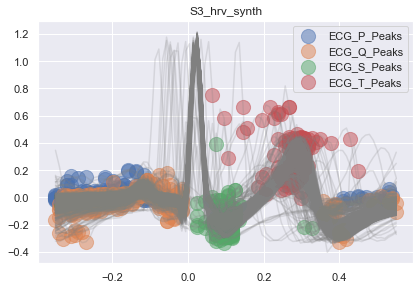

In [16]:
# ECG HRV modulation
hrv_mod=ECG_HRV_Modulator(P_ID_in=P_ID_in,P_ID_out=P_ID_out,
                              path=ckpt_path,Fs_out=Fs_out)
ecg_hrv_mod,_=hrv_mod(ecg_in,Fs=Fs_in)

morph_features,hrv_features= hrv_mod.analyse_signal(ecg_hrv_mod
                            ,Fs=Fs_out,title_hrv=P_ID_out+'_hrv_synth',
                            title_morph=P_ID_in+'_hrv_synth')